In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
0,M,18.0,"1,674",52.9,790,655,851
1,M,18.0,"1,678",55.8,825,654,880
2,M,23.0,"1,790",57.5,800,650,870
3,F,37.0,"1,626",66.3,962,820,997
4,M,24.0,"1,722",69.2,948,785,937


In [4]:
# checking for nulls in the dataframe
train_df.isnull().sum()

gender                 1
age                    1
height                 2
weight                 7
bust_circumference     4
waist_circumference    4
hip_circumference      4
dtype: int64

In [5]:
# checking for nulls in the dataframe
test_df.isnull().sum()

gender    0
age       0
height    0
weight    1
dtype: int64

In [6]:
# understanding the nature of the nulls
null_rows = train_df[train_df.isnull().any(axis=1)]
null_rows

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
1801,F,19.0,"1,620",NaN,775,622,850
2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3258,M,17.0,"1,762",NaN,836,690,900
3303,M,31.0,"1,725",NaN,NaN,NaN,NaN
3752,M,20.0,"1,821",NaN,931,762,942
4189,M,22.0,"1,730",NaN,NaN,NaN,NaN
4603,F,63.0,"1,573",NaN,"1,002",910,928
4876,M,37.0,NaN,83.9,NaN,NaN,NaN


In [7]:
# understanding the nature of the nulls
null_rows = test_df[test_df.isnull().any(axis=1)]
null_rows

,gender,age,height,weight
413,M,17.0,"1,740",NaN


In [8]:
# removing rows without data on circumferences
filtered_train = train_df.dropna()
filtered_test = test_df.dropna()
filtered_train.isnull().sum()

gender                 0
age                    0
height                 0
weight                 0
bust_circumference     0
waist_circumference    0
hip_circumference      0
dtype: int64

In [9]:
# checking for outliers
filtered_train.describe(include='all')

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
count,5129,5129.000000,5129,5129.000000,5129,5129,5129
unique,2,NaN,430,NaN,437,486,347
top,F,NaN,"1,580",NaN,895,760,930
freq,2573,NaN,56,NaN,70,59,90
mean,NaN,31.588224,NaN,63.872431,NaN,NaN,NaN
std,NaN,14.429656,NaN,12.648540,NaN,NaN,NaN
min,NaN,15.000000,NaN,36.800000,NaN,NaN,NaN
25%,NaN,19.000000,NaN,54.600000,NaN,NaN,NaN
50%,NaN,28.000000,NaN,61.700000,NaN,NaN,NaN
75%,NaN,40.000000,NaN,71.500000,NaN,NaN,NaN


In [10]:
# checking the balance of the dataset
gender_counts = filtered_train['gender'].value_counts().reset_index()
gender_counts

,gender,count
0,F,2573
1,M,2556


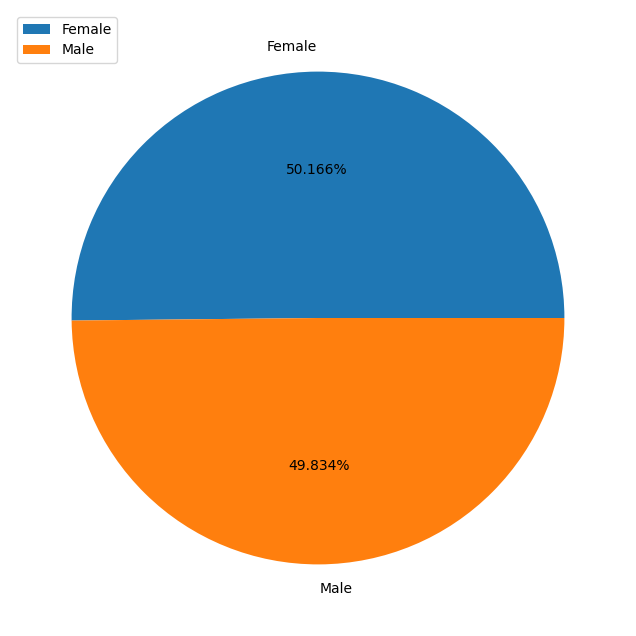

In [11]:
plt.figure(figsize=(8,8))
plt.pie(gender_counts['count'], labels=['Female', 'Male'], autopct='%1.3f%%',explode=[0,0])
plt.legend(loc='upper left')
plt.show()

In [12]:
# checking the data types per column
filtered_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5129 entries, 0 to 5136
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               5129 non-null   object 
 1   age                  5129 non-null   float64
 2   height               5129 non-null   object 
 3   weight               5129 non-null   float64
 4   bust_circumference   5129 non-null   object 
 5   waist_circumference  5129 non-null   object 
 6   hip_circumference    5129 non-null   object 
dtypes: float64(2), object(5)
memory usage: 320.6+ KB


In [13]:
# standardizing numeric data
def clean_and_convert_columns(df, columns):
    df = df.copy()
    for col in columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .astype(float)
        )
    return df

cleaned_train =  clean_and_convert_columns(filtered_train, ['height', 'bust_circumference', 'waist_circumference', 'hip_circumference'])
cleaned_test  =  clean_and_convert_columns(filtered_test, ['height'])

In [14]:
def plot_boxplot(data, x_col, y_col):
    num_plots = len(y_col)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # width scales with number of plots

    if num_plots == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, y_col in zip(axes, y_col):
        sns.boxplot(x=x_col, y=y_col, data=data, ax=ax)
        ax.set_title(f'{y_col} vs {x_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    plt.tight_layout()
    plt.show()

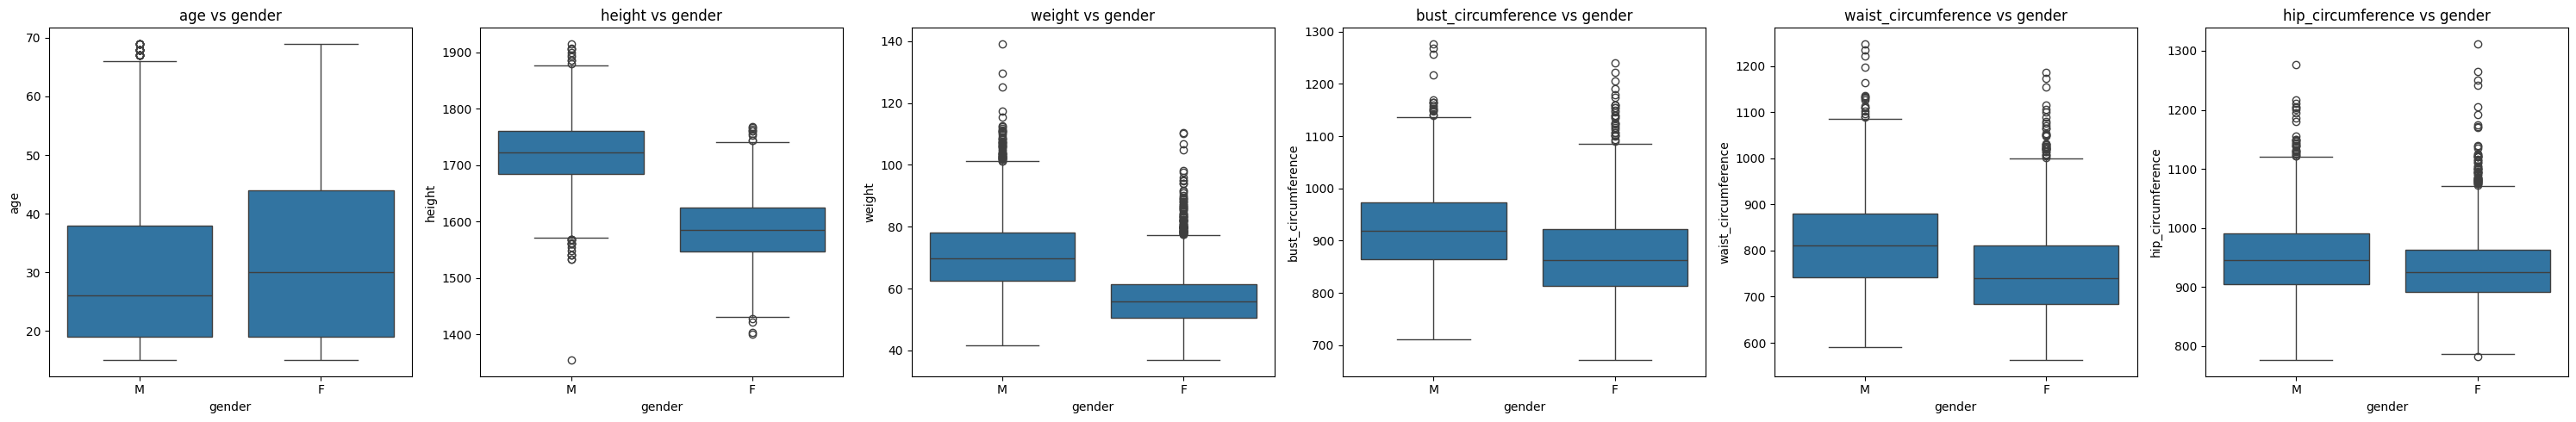

In [15]:
# Creating box plot to check nature of data
plot_boxplot(cleaned_train, 'gender', ['age', 'height', 'weight', 'bust_circumference', 'waist_circumference', 'hip_circumference'])

In [16]:
# Defining features available for both datasets
le = LabelEncoder()
cleaned_train['gender_encoded'] = le.fit_transform(cleaned_train['gender']) 
cleaned_test['gender_encoded'] = le.transform(cleaned_test['gender'])  
base_features = ['gender_encoded', 'age', 'height', 'weight']

In [17]:
# Training regression models for each body measurement
def train_and_predict_body_part(target):
    lin_reg = LinearRegression()
    lin_reg.fit(cleaned_train[base_features], cleaned_train[target])
    cleaned_test[target] = lin_reg.predict(cleaned_test[base_features])
    return lin_reg

In [18]:
def cross_validate_regression(df, feature_cols, target_col, n_splits=5, random_state=42):
    X = df[feature_cols]
    y = df[target_col]
    model = LinearRegression()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae_scores.append(mean_absolute_error(y_val, y_pred))
        mse_scores.append(mean_squared_error(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

    mae = np.mean(mae_scores)
    mse = np.mean(mse_scores)
    rmse = np.sqrt(mse)
    r2 = np.mean(r2_scores)

    print(f" Cross-Validation for: {target_col}")
    print(f"  - MAE : {mae:.2f}")
    print(f"  - MSE : {mse:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R²  : {r2:.3f}")
    print("-" * 40)

    return

def cross_validate_xgboost(df, feature_cols, target_col, n_splits=5, random_state=42):
    X = df[feature_cols]
    y = df[target_col]
    model = XGBRegressor(random_state=random_state, n_estimators=100, max_depth=3, learning_rate=0.1)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    mae_scores, mse_scores, r2_scores = [], [], []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae_scores.append(mean_absolute_error(y_val, y_pred))
        mse_scores.append(mean_squared_error(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

    mae = np.mean(mae_scores)
    mse = np.mean(mse_scores)
    rmse = np.sqrt(mse)
    r2 = np.mean(r2_scores)

    print(f" XGBoost Evaluation for: {target_col}")
    print(f"  - MAE : {mae:.2f}")
    print(f"  - MSE : {mse:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R²  : {r2:.3f}")
    print("-" * 40)

    return

In [19]:
cross_validate_regression(df=cleaned_train, feature_cols=base_features, target_col='bust_circumference')
cross_validate_regression(df=cleaned_train, feature_cols=base_features, target_col='waist_circumference')
cross_validate_regression(df=cleaned_train, feature_cols=base_features, target_col='hip_circumference')

cross_validate_xgboost(df=cleaned_train, feature_cols=base_features, target_col='bust_circumference')
cross_validate_xgboost(df=cleaned_train, feature_cols=base_features, target_col='waist_circumference')
cross_validate_xgboost(df=cleaned_train, feature_cols=base_features, target_col='hip_circumference')

 Cross-Validation for: bust_circumference
  - MAE : 24.62
  - MSE : 1016.38
  - RMSE: 31.88
  - R²  : 0.860
----------------------------------------
 Cross-Validation for: waist_circumference
  - MAE : 25.60
  - MSE : 1132.54
  - RMSE: 33.65
  - R²  : 0.889
----------------------------------------
 Cross-Validation for: hip_circumference
  - MAE : 18.23
  - MSE : 572.03
  - RMSE: 23.92
  - R²  : 0.851
----------------------------------------
 XGBoost Evaluation for: bust_circumference
  - MAE : 23.76
  - MSE : 952.43
  - RMSE: 30.86
  - R²  : 0.869
----------------------------------------
 XGBoost Evaluation for: waist_circumference
  - MAE : 25.97
  - MSE : 1149.01
  - RMSE: 33.90
  - R²  : 0.888
----------------------------------------
 XGBoost Evaluation for: hip_circumference
  - MAE : 17.80
  - MSE : 549.18
  - RMSE: 23.43
  - R²  : 0.857
----------------------------------------


In [20]:
train_and_predict_body_part('bust_circumference')
train_and_predict_body_part('waist_circumference')
train_and_predict_body_part('hip_circumference')

LinearRegression()

In [21]:
cleaned_test

,gender,age,height,weight,gender_encoded,bust_circumference,waist_circumference,hip_circumference
0,M,27.0,1729.0,74.7,1,942.355146,839.112009,972.935661
1,M,25.0,1645.0,58.6,1,849.270182,738.471471,889.445864
2,M,28.0,1786.0,75.2,1,931.611682,821.864750,971.626721
3,M,19.0,1686.0,60.8,1,847.228711,729.216398,902.532377
4,M,24.0,1764.0,68.3,1,884.535774,767.526656,936.735079
...,...,...,...,...,...,...,...,...
1277,F,33.0,1618.0,54.0,0,843.823013,719.298721,912.702560
1278,F,25.0,1549.0,56.4,0,870.653738,752.692201,934.853587
1279,F,28.0,1623.0,58.5,0,868.785088,745.116425,940.296534
1280,F,34.0,1566.0,55.4,0,868.789612,753.520181,923.182155


In [22]:
# Adding more features to the dataset
def add_features(df):
    df['whr'] = df['waist_circumference'] / df['hip_circumference']
    df['bhr'] = df['bust_circumference'] / df['hip_circumference']
    df['bwr'] = df['bust_circumference'] / df['waist_circumference']
    
    return df


In [23]:
add_features(cleaned_train)
add_features(cleaned_test)

,gender,age,height,weight,gender_encoded,bust_circumference,waist_circumference,hip_circumference,whr,bhr,bwr
0,M,27.0,1729.0,74.7,1,942.355146,839.112009,972.935661,0.862454,0.968569,1.123039
1,M,25.0,1645.0,58.6,1,849.270182,738.471471,889.445864,0.830260,0.954831,1.150038
2,M,28.0,1786.0,75.2,1,931.611682,821.864750,971.626721,0.845865,0.958816,1.133534
3,M,19.0,1686.0,60.8,1,847.228711,729.216398,902.532377,0.807967,0.938724,1.161834
4,M,24.0,1764.0,68.3,1,884.535774,767.526656,936.735079,0.819364,0.944275,1.152450
...,...,...,...,...,...,...,...,...,...,...,...
1277,F,33.0,1618.0,54.0,0,843.823013,719.298721,912.702560,0.788098,0.924532,1.173119
1278,F,25.0,1549.0,56.4,0,870.653738,752.692201,934.853587,0.805144,0.931326,1.156719
1279,F,28.0,1623.0,58.5,0,868.785088,745.116425,940.296534,0.792427,0.923948,1.165972
1280,F,34.0,1566.0,55.4,0,868.789612,753.520181,923.182155,0.816220,0.941081,1.152975


In [24]:
def compare_models(train_df, feature_cols, gender_col='gender_encoded', random_state=42):
    # Split data
    X = train_df[feature_cols]
    y = train_df[gender_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Models to compare
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=random_state),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state)
    }

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        print(f"\n {name} Evaluation:")
        print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
        print(classification_report(y_val, y_pred, target_names=le.classes_))

In [25]:
features = ['age', 'height', 'weight', 'bust_circumference', 'waist_circumference', 'hip_circumference', 'whr',	'bhr', 'bwr']
compare_models(train_df=cleaned_train, feature_cols=features)


 Logistic Regression Evaluation:
Accuracy: 0.9600
              precision    recall  f1-score   support

           F       0.98      0.94      0.96       531
           M       0.94      0.98      0.96       495

    accuracy                           0.96      1026
   macro avg       0.96      0.96      0.96      1026
weighted avg       0.96      0.96      0.96      1026


 Decision Tree Evaluation:
Accuracy: 0.9298
              precision    recall  f1-score   support

           F       0.94      0.92      0.93       531
           M       0.92      0.94      0.93       495

    accuracy                           0.93      1026
   macro avg       0.93      0.93      0.93      1026
weighted avg       0.93      0.93      0.93      1026


 Random Forest Evaluation:
Accuracy: 0.9581
              precision    recall  f1-score   support

           F       0.96      0.96      0.96       531
           M       0.96      0.96      0.96       495

    accuracy                           0.

In [26]:
# Prepare training data
X_train = cleaned_train[features]
y_train = cleaned_train['gender_encoded']

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Preparing test data
X_test = cleaned_test[features] 

# Predict gender
y_pred_test = dt_model.predict(X_test)

# Decode gender back to labels
cleaned_test['predicted_gender'] = le.inverse_transform(y_pred_test)

In [35]:
def evaluate_gender_classification(predicted_test, actual_col='gender', predicted_col='predicted_gender'):
    # Consistent encoding
    le = LabelEncoder()
    y_true = predicted_test[actual_col]
    y_pred = predicted_test[predicted_col]

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f" Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n Confusion Matrix:")
    print(cm)

    # Detailed Report
    report = classification_report(y_true, y_pred)
    print("\n Classification Report:")
    print(report)

    return

In [36]:
evaluate_gender_classification(cleaned_test)

 Accuracy: 0.9251

 Confusion Matrix:
[[594  54]
 [ 42 591]]

 Classification Report:
              precision    recall  f1-score   support

           F       0.93      0.92      0.93       648
           M       0.92      0.93      0.92       633

    accuracy                           0.93      1281
   macro avg       0.93      0.93      0.93      1281
weighted avg       0.93      0.93      0.93      1281



In [30]:
# Saving predictions to CSV
cleaned_test.to_csv('test_with_gender_predictions.csv', index=False)